# Data Exploration of UA/UAA Ticker Dataset

The notebook will compile and explore the UA/UAA Ticker Dataset that will be used in future analysis to capture statistical arbitrage. 

We will analyze the stocks of UA and UAA, which are Under Armour's dual listed class A and class C stocks. This pair should share as very many intrinsic characteristics, with the exception of voting rights. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import datetime

import glob

%load_ext autoreload
%autoreload 2

## Download Data from Alpha_vantage

In [17]:
import time

df_ua = pd.DataFrame()
df_uaa = pd.DataFrame()

for i in range(1, 3):
    for j in range(1, 13):
        ua_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=UA&interval=5min&slice=year' + str(i) + 'month' + str(j) + '&apikey=GMEJ0VX1SHB4YZCN'
        uaa_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=UAA&interval=5min&slice=year' + str(i) + 'month' + str(j) + '&apikey=GMEJ0VX1SHB4YZCN'
        df = pd.read_csv(ua_url)
        df_ua = pd.concat([df_ua, df], axis=0)
        time.sleep(15) # API call frequency is 5 calls per minute and 500 calls per day
        df = pd.read_csv(uaa_url)
        df_uaa = pd.concat([df_uaa, df], axis=0)
        time.sleep(15) # API call frequency is 5 calls per minute and 500 calls per day

In [18]:
df_uaa.tail(10)

,time,open,high,low,close,volume
1946,2021-04-16 10:05:00,21.905,21.965,21.870,21.910,92127
1947,2021-04-16 10:00:00,21.935,21.985,21.910,21.910,29761
1948,2021-04-16 09:55:00,22.095,22.095,21.935,21.935,31778
1949,2021-04-16 09:50:00,22.030,22.100,22.020,22.090,23227
1950,2021-04-16 09:45:00,22.010,22.060,22.000,22.020,20481
1951,2021-04-16 09:40:00,22.090,22.130,22.030,22.040,43571
1952,2021-04-16 09:35:00,22.120,22.200,22.080,22.100,159394
1953,2021-04-16 09:15:00,22.100,22.100,22.100,22.100,414
1954,2021-04-16 07:10:00,22.030,22.030,22.030,22.030,100
1955,2021-04-16 05:15:00,22.010,22.010,22.010,22.010,100


In [19]:
# save data to local csv files
df_ua.to_csv('./data/ua.csv', index=False)
df_uaa.to_csv('./data/uaa.csv', index=False)

In [20]:
df_ticker = pd.DataFrame()

df_ua['ticker'] = "UA"
df_uaa['ticker'] = "UAA"
df_ticker = df_ticker.append(df_ua, ignore_index=True)
df_ticker = df_ticker.append(df_uaa, ignore_index=True)

# Data Exploration

Our dataset contains snapshots of UA and UAA over the span of roughly 2 years at the 5 minute-level resolution. 

Our data was gathered from Alpha Vantage API. 

In [21]:
df_ticker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91371 entries, 0 to 91370
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    91371 non-null  object 
 1   open    91371 non-null  float64
 2   high    91371 non-null  float64
 3   low     91371 non-null  float64
 4   close   91371 non-null  float64
 5   volume  91371 non-null  int64  
 6   ticker  91371 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 4.9+ MB


Text(0.5, 1.0, 'Number of NaNs per column')

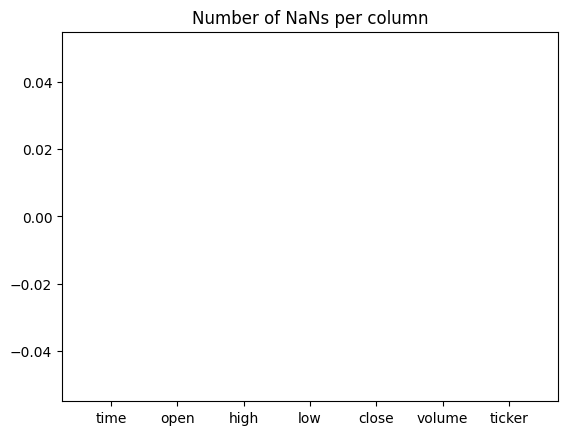

In [22]:
plt.figure()

cols = df_ticker.columns
counts = [df_ticker[x].isna().sum() for x in cols]

plt.bar(cols, counts)
plt.title("Number of NaNs per column")

In [23]:
def convert_datetime(time):
    t = time.astype("str")
    year = t.apply(lambda x: x[:4])
    month = t.apply(lambda x: x[5:7])
    day = t.apply(lambda x: x[8:10])
    hour = t.apply(lambda x: x[11:13])
    minute = t.apply(lambda x: x[14:16])

    return pd.to_datetime(dict(year=year, month=month, day=day, hour=hour, minute=minute))

In [24]:
df_ticker["TIMESTAMP"] = convert_datetime(df_ticker['time'])

df_ticker = df_ticker.sort_values(by='TIMESTAMP')

df_ua = df_ticker.query("ticker =='UA'").reset_index()
df_uaa = df_ticker.query("ticker =='UAA'").reset_index()

In [25]:
print(df_ua.shape)
print(df_uaa.shape)

(45128, 9)
(46243, 9)


The UA dataset has a different length than the UAA dataset, indicating that these dataframes have missing rows. We should attempt to fill in these columns with duplicate values for the price and 0 volume for the sake of our time series analysis. 

In [26]:
ua_missing_times = set(df_ua.TIMESTAMP).difference(set(df_uaa.TIMESTAMP))

uaa_missing_times = set(df_uaa.TIMESTAMP).difference(set(df_ua.TIMESTAMP))

total_missing_times = ua_missing_times.union(uaa_missing_times)

In [33]:
df_ticker = df_ticker[~df_ticker.TIMESTAMP.isin(total_missing_times)]

In [34]:
df_ua = df_ticker.query("ticker =='UA'").reset_index()
df_uaa = df_ticker.query("ticker =='UAA'").reset_index()

print(df_ua.shape)
print(df_uaa.shape)

(41808, 9)
(41808, 9)


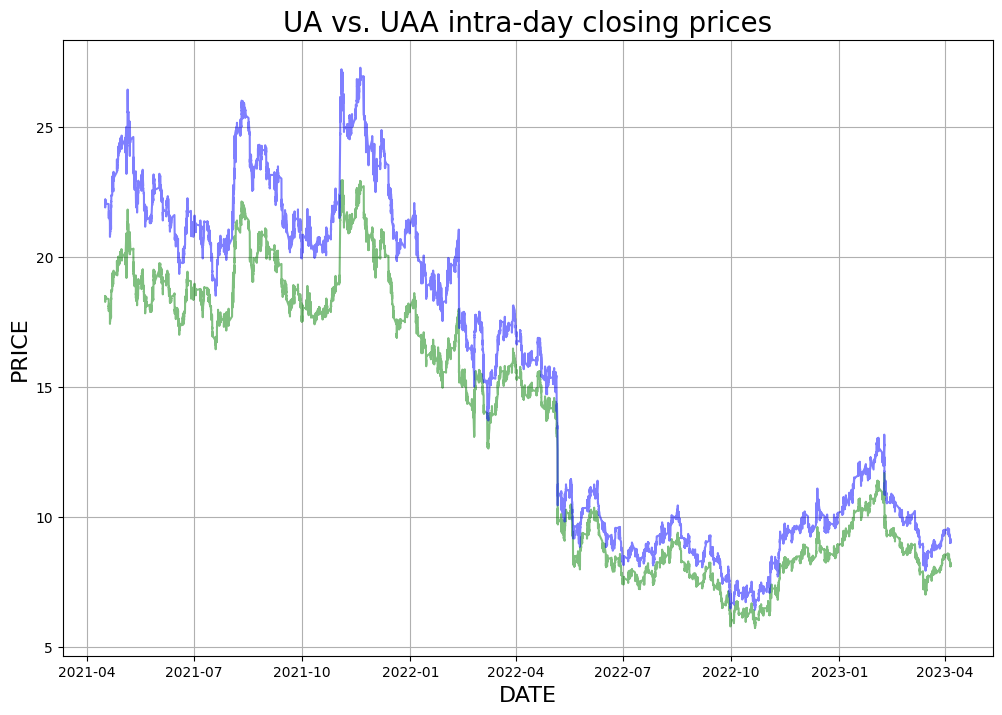

In [36]:
plt.figure(figsize=(12, 8))

plt.plot(df_ua["TIMESTAMP"], df_ua["close"], color='green', alpha=0.5, label='UA')
plt.plot(df_uaa["TIMESTAMP"], df_uaa["close"], color='blue', alpha=0.5, label='UAA')

plt.title('UA vs. UAA intra-day closing prices', fontsize=20)
plt.xlabel('DATE', fontsize=16)
plt.ylabel('PRICE', fontsize=16)

plt.grid()

It can be seen here that the relationship between UA and UAA shifts through our timeframe. The spread of the pricing of the stock has become narrower as time has progressed. 

This means that any potential means of capturing statistical arbitrage should factor this shift throughout time and adjust accordingly. 

In [38]:
df_ua.to_csv('./data/df_ua.csv')
df_uaa.to_csv('./data/df_uaa.csv')